In [1]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Dropout, Flatten,
                                     Dense, LSTM, MultiHeadAttention, Concatenate, Reshape)
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tqdm import tqdm
from scipy.stats import ttest_ind
import pandas as pd
import shap
from tensorflow.keras.saving import register_keras_serializable
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Reshape
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.transform import resize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# =============================================================================
# --- Configuration ---
# =============================================================================

# --- 1. Core Paths ---
ITALIAN_DATASET = "ITALIAN_DATASET"
UAMS_DATASET = "UAMS_DATASET"
NEUROVOZ_DATASET = "NEUROVOZ_DATASET"
MPOWER_DATASET = "MPOWER_DATASET"
SYNTHETIC_DATASET = "SYNTHETIC_DATASET"

MODE_ALL_VALIDS = "ALL_VALIDS"
MODE_A = "A"

FEATURE_MODE_BASIC = "BASIC"        # mel_spectrogram, mfcc, spectrogram
FEATURE_MODE_ALL = "ALL"            # basic + fsc
FEATURE_MODE_DEFAULT = "DEFAULT"

MODEL_NAME = "cnn_att_lstm"

# /////////// SELCET HERE \\\\\\\\\\\
# ----------------------------------
DATASET = UAMS_DATASET
MODE = MODE_A
FEATURE_MODE = FEATURE_MODE_DEFAULT
# ----------------------------------

In [2]:
dataset = ""
if DATASET == NEUROVOZ_DATASET:
    dataset = "Neurovoz"
elif DATASET == UAMS_DATASET:
    dataset = "UAMS"
elif DATASET == MPOWER_DATASET:
    dataset = "mPower"
elif DATASET == SYNTHETIC_DATASET:
    dataset = "Synthetic"
elif DATASET == ITALIAN_DATASET:
    dataset = "Italian"

# Path Setup
FEATURES_FILE_PATH = os.path.join(os.getcwd(), dataset, "data", f"features_{MODE}_{FEATURE_MODE}.npz")

MODEL_PATH = os.path.join(os.getcwd(), dataset, f"results_{MODE}_{FEATURE_MODE}", MODEL_NAME)
os.makedirs(MODEL_PATH, exist_ok=True)
EVALUATION_FILE_PATH = os.path.join(MODEL_PATH, "evaluation.csv")
HISTORY_SAVE_PATH = os.path.join(MODEL_PATH, "history.csv")
BEST_MODEL_PATH = os.path.join(MODEL_PATH, "best_model.keras")

SHAP_OUTPUT_PATH = os.path.join(MODEL_PATH, "shap_analysis")
GRADCAM_OUTPUT_PATH = os.path.join(MODEL_PATH, "gradcam_analysis")
os.makedirs(SHAP_OUTPUT_PATH, exist_ok=True)
os.makedirs(GRADCAM_OUTPUT_PATH, exist_ok=True)

# Hyperparameters
EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
L2_STRENGTH = 0.01

# Model Checkpoint Callback
checkpoint_cb = ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)

In [3]:
def load_data(feature_file_path):

    print(f"--- Loading data from {feature_file_path} ---")
    with np.load(feature_file_path) as data:
        labels = data['labels']
        mel_spectrogram = data['mel_spectrogram']
        mfcc = data['mfcc']
        X = np.concatenate((mel_spectrogram, mfcc), axis=-1)
        return X, labels


# =============================================================================
# --- Model Architecture ---
# =============================================================================

@register_keras_serializable()
class ParkinsonDetectorModel(Model):
    def __init__(self, input_shape, **kwargs):
        super(ParkinsonDetectorModel, self).__init__(**kwargs)
        self.input_shape_config = input_shape

        self.reshape_in = Reshape((input_shape[0], input_shape[1], 1))
        self.conv1a = Conv2D(64, 5, activation='relu', kernel_regularizer=l2(L2_STRENGTH), padding='same')
        self.conv1b = Conv2D(64, 5, activation='relu', kernel_regularizer=l2(L2_STRENGTH), padding='same')
        self.pool1 = MaxPooling2D(5)
        self.drop1 = Dropout(DROPOUT_RATE)
        self.conv2a = Conv2D(64, 5, activation='relu', kernel_regularizer=l2(L2_STRENGTH), padding='same')
        self.conv2b = Conv2D(64, 5, activation='relu', kernel_regularizer=l2(L2_STRENGTH), padding='same', name='last_conv_layer')
        self.pool2 = MaxPooling2D(5, name='cnn_output')
        self.drop2 = Dropout(DROPOUT_RATE)
        self.flatten_cnn = Flatten()
        self.attention = MultiHeadAttention(num_heads=2, key_dim=64, name='attention_output')
        self.flatten_att = Flatten()
        self.lstm1 = LSTM(128, return_sequences=True)
        self.lstm2 = LSTM(128, return_sequences=False, name='lstm_output')
        self.drop_lstm = Dropout(DROPOUT_RATE)
        self.concat = Concatenate()
        self.dense_bottleneck = Dense(128, activation='relu', name='bottleneck_features')
        self.dense_output = Dense(1, activation='sigmoid')


    def call(self, inputs, training=False):
        x = self.reshape_in(inputs)
        x = self.conv1a(x)
        x = self.conv1b(x)
        x = self.pool1(x)
        x = self.drop1(x, training=training)
        x = self.conv2a(x)
        x = self.conv2b(x)
        cnn_branch_output = self.pool2(x)
        x = self.drop2(cnn_branch_output, training=training)

        cnn_flat = self.flatten_cnn(x)

        shape = tf.shape(x)
        sequence = tf.reshape(x, [-1, shape[1] * shape[2], shape[3]])

        att_branch_output = self.attention(query=sequence, key=sequence, value=sequence)
        att_flat = self.flatten_att(att_branch_output)

        lstm_seq = self.lstm1(sequence)
        lstm_branch_output = self.lstm2(lstm_seq)
        lstm_out = self.drop_lstm(lstm_branch_output, training=training)

        concatenated = self.concat([cnn_flat, att_flat, lstm_out])
        bottleneck = self.dense_bottleneck(concatenated)
        final_output = self.dense_output(bottleneck)

        return final_output

    def get_config(self):
        config = super(ParkinsonDetectorModel, self).get_config()
        config.update({"input_shape": self.input_shape_config})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def build_model(input_shape: tuple) -> Model:
    """Builds the hybrid model by wrapping the custom class in a Functional API model."""
    print("--- Building the model ---")
    inputs = Input(shape=input_shape)
    parkinson_detector = ParkinsonDetectorModel(input_shape=input_shape)
    outputs = parkinson_detector(inputs)
    model = Model(inputs=inputs, outputs=outputs)
    print("Model built successfully.")
    return model

# =============================================================================
# --- Model Performance ---
# =============================================================================
def save_metrics_to_csv(y_true, y_pred_proba, filename="classification_report.csv", threshold=0.5):
    y_true = np.array(y_true)
    y_pred_binary = (np.array(y_pred_proba) > threshold).astype(int)

    cm = confusion_matrix(y_true, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    total_samples = cm.sum()
    if total_samples == 0:
        tn_percent, fp_percent, fn_percent, tp_percent = 0, 0, 0, 0
    else:
        tn_percent = (tn / total_samples) * 100
        fp_percent = (fp / total_samples) * 100
        fn_percent = (fn / total_samples) * 100
        tp_percent = (tp / total_samples) * 100

    precision = precision_score(y_true, y_pred_binary, zero_division=0)
    recall = recall_score(y_true, y_pred_binary, zero_division=0)
    f1 = f1_score(y_true, y_pred_binary, zero_division=0)
    sensitivity = recall

    report_data = {
        'Metric': [
            'True Positive (TP)',
            'True Negative (TN)',
            'False Positive (FP)',
            'False Negative (FN)',
            'Precision',
            'Recall (Sensitivity)',
            'F1-Score'
        ],
        'Value': [
            f"{tp} ({tp_percent:.2f}%)",
            f"{tn} ({tn_percent:.2f}%)",
            f"{fp} ({fp_percent:.2f}%)",
            f"{fn} ({fn_percent:.2f}%)",
            f"{precision:.4f}",
            f"{recall:.4f}",
            f"{f1:.4f}"
        ]
    }
    df = pd.DataFrame(report_data)

    try:
        df.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"The evaluation results is stored: {filename}")
    except Exception as e:
        print(f"Erorr while saving the evaluation report: {e}")
# =============================================================================
# --- Model Explainability (SHAP & Grad-CAM) ---
# =============================================================================


In [4]:
def generate_feature_map_info(npz_file_path):
    """
    Dynamically generates feature layout information (color mask, names, colors)
    by inspecting the contents of an .npz file.
    """
    if not os.path.exists(npz_file_path):
        print(f"Error: File not found at '{npz_file_path}'")
        return None

    feature_layout = {}
    print(f"Inspecting file for feature map info: {npz_file_path}")

    with np.load(npz_file_path) as data:
        ignore_keys = {'labels', 'sex', 'age', 'X', 'y'}
        feature_keys = [key for key in data.files if key not in ignore_keys]

        if not feature_keys:
            print("Error: No feature arrays found in the .npz file.")
            return None

        for key in sorted(feature_keys):
            arr_shape = data[key].shape

            if len(arr_shape) == 1:
                num_rows = 1
            elif len(arr_shape) >= 2:
                num_rows = arr_shape[1]
            else:
                continue

            feature_layout[key] = num_rows

    colors = plt.get_cmap('Paired', len(feature_layout))
    feature_names = list(feature_layout.keys())
    total_rows = sum(feature_layout.values())
    time_steps_for_visual = total_rows

    color_mask = np.zeros((total_rows, time_steps_for_visual), dtype=int)

    current_row = 0
    for i, (name, num_rows) in enumerate(feature_layout.items()):
        color_mask[current_row : current_row + num_rows, :] = i
        current_row += num_rows

    legend_patches = [mpatches.Patch(color=colors(i), label=f"{name} ({feature_layout[name]} rows)")
                      for i, name in enumerate(feature_names)]

    return {
        'color_mask': color_mask,
        'feature_layout': feature_layout,
        'feature_names': feature_names,
        'colors': colors,
        'legend_patches': legend_patches,
        'total_rows': total_rows
    }

def run_full_shap_analysis(model, X_train, X_test, y_test, output_path, features_npz_path, samples_per_class = 50, top_n=20):
    """
    Run SHAP analysis with balanced sample selection.
    Generates plots with two side-by-side, perfectly SQUARE and equal-sized subplots.
    """
    print("\n--- Running Full SHAP Analysis ---")
    os.makedirs(output_path, exist_ok=True)

    feature_map_info = generate_feature_map_info(features_npz_path)
    if feature_map_info is None: return

    legend_patches = feature_map_info['legend_patches']
    total_rows = feature_map_info['total_rows']

    # Balanced sample selection logic...
    healthy_indices = np.where(y_test == 0)[0]
    parkinson_indices = np.where(y_test == 1)[0]
    num_healthy_to_select = min(samples_per_class, len(healthy_indices))
    num_parkinson_to_select = min(samples_per_class, len(parkinson_indices))
    print(f"Attempting to select {num_healthy_to_select} healthy and {num_parkinson_to_select} Parkinson's samples.")
    selected_healthy_indices = np.random.choice(healthy_indices, num_healthy_to_select, replace=False)
    selected_parkinson_indices = np.random.choice(parkinson_indices, num_parkinson_to_select, replace=False)
    final_indices = np.concatenate([selected_healthy_indices, selected_parkinson_indices])
    np.random.shuffle(final_indices)
    test_samples = X_test[final_indices]
    y_true_samples = y_test[final_indices]

    print(f"Calculating SHAP values for {len(test_samples)} balanced samples...")
    explainer = shap.GradientExplainer(model, X_train[:50].astype(np.float32))
    shap_values_list = []
    for sample in tqdm(test_samples, desc="SHAP Progress"):
        sample_batch = np.expand_dims(sample, axis=0).astype(np.float32)
        sv = explainer.shap_values(sample_batch)
        if isinstance(sv, list): sv = sv[0]
        shap_values_list.append(sv)
    shap_values = np.vstack(shap_values_list)
    print(f"\nSHAP values shape: {shap_values.shape}, Test samples shape: {test_samples.shape}")
    if shap_values.shape[1] != total_rows:
        print(f"⚠️ Warning: SHAP values feature rows ({shap_values.shape[1]}) do not match total_rows from NPZ ({total_rows}).")
    actual_data_time_steps = shap_values.shape[2]

    # ... (Global Top-N Pixel Bar Plot code remains the same) ...
    flat_shap = shap_values.reshape(shap_values.shape[0], -1)
    mean_abs = np.mean(np.abs(flat_shap), axis=0)
    top_idx = np.argsort(mean_abs)[::-1][:top_n]
    coords = [np.unravel_index(i, (shap_values.shape[1], shap_values.shape[2])) for i in top_idx]
    labels = [f"T{t} F{f}" for t, f in coords]
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(top_idx)), mean_abs[top_idx])
    plt.xticks(range(len(top_idx)), labels, rotation=45, ha="right")
    plt.title(f"Top-{top_n} Global SHAP Features (time × frequency bins)")
    plt.xlabel("Time Bin × Frequency Bin")
    plt.ylabel("Mean |SHAP value|")
    plt.tight_layout()
    plt.savefig(os.path.join(output_path, "shap_global_bar.png"), dpi=300, bbox_inches="tight")
    plt.close()
    print("-> Saved 'shap_global_bar.png'")

    def plot_aligned_heatmap(heatmap_data, title, filename_suffix, cmap, label, vmin=None, vmax=None):
        """
        Plots the SHAP heatmap and Feature Map in two perfectly square, side-by-side subplots.
        """

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))

        ax_shap, ax_feature_map = axes[0], axes[1]

        # --- SHAP Heatmap (Left Subplot) ---
        img = ax_shap.imshow(heatmap_data, cmap=cmap, aspect='auto', interpolation='nearest', vmin=vmin, vmax=vmax)
        ax_shap.set_title(title, fontsize=12)
        ax_shap.set_xlabel(f"Time Steps (Actual: {actual_data_time_steps})", fontsize=10)
        ax_shap.set_ylabel(f"Feature Rows ({total_rows})", fontsize=10)

        # This prevents the colorbar from shrinking the main plot.
        divider = make_axes_locatable(ax_shap)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        fig.colorbar(img, cax=cax, label=label)

        # --- Feature Map (Right Subplot) ---
        aligned_color_mask = np.zeros((total_rows, actual_data_time_steps), dtype=int)
        current_row = 0
        for i, (name, num_rows) in enumerate(feature_map_info['feature_layout'].items()):
            original_idx = feature_map_info['feature_names'].index(name)
            aligned_color_mask[current_row : current_row + num_rows, :] = original_idx
            current_row += num_rows

        ax_feature_map.imshow(aligned_color_mask, cmap=feature_map_info['colors'], aspect='auto', interpolation='nearest')
        ax_feature_map.set_title("Feature Map", fontsize=12)
        ax_feature_map.set_xlabel(f"Time Steps (Visual: {actual_data_time_steps})", fontsize=10)
        # The y-axis label is shared, so we can turn it off for the second plot for a cleaner look
        ax_feature_map.tick_params(axis='y', labelleft=False)

        ax_feature_map.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=8)

        fig.suptitle(f"SHAP Analysis: {title}", fontsize=16, fontweight='bold')

        # Use standard tight_layout; figsize and dedicated colorbar axis handle the rest.
        plt.tight_layout(rect=[0, 0, 1, 0.95]) # rect adjusts for suptitle

        plt.savefig(os.path.join(output_path, f"shap_aligned_{filename_suffix}.png"), dpi=300)
        plt.close(fig)
        print(f"-> Saved 'shap_aligned_{filename_suffix}.png'")

    hc_mask, pd_mask = (y_true_samples == 0), (y_true_samples == 1)
    # ... (The rest of the function that calls plot_aligned_heatmap remains the same) ...
    if np.any(hc_mask):
        hc_mean = shap_values[hc_mask].mean(axis=0).squeeze()
        plot_aligned_heatmap(hc_mean, "Average SHAP Heatmap - Healthy", "summary_healthy", "bwr", "Mean SHAP Value")
    if np.any(pd_mask):
        pd_mean = shap_values[pd_mask].mean(axis=0).squeeze()
        plot_aligned_heatmap(pd_mean, "Average SHAP Heatmap - Parkinson", "summary_parkinson", "bwr", "Mean SHAP Value")
    if np.any(hc_mask) and np.any(pd_mask):
        diff_map = pd_mean - hc_mean
        max_abs_diff = np.max(np.abs(diff_map))
        plot_aligned_heatmap(diff_map, "SHAP Difference Heatmap (Parkinson - Healthy)", "difference", "seismic", "Δ SHAP (PD - HC)", vmin=-max_abs_diff, vmax=max_abs_diff)
    if np.any(hc_mask) and np.any(pd_mask) and np.sum(hc_mask) > 1 and np.sum(pd_mask) > 1:
        hc_vals = shap_values[hc_mask].reshape(np.sum(hc_mask), -1)
        pd_vals = shap_values[pd_mask].reshape(np.sum(pd_mask), -1)
        t_stat, p_vals = ttest_ind(pd_vals, hc_vals, axis=0, equal_var=False)
        p_map = p_vals.reshape(shap_values.shape[1], shap_values.shape[2])
        plot_aligned_heatmap(p_map, "Statistical Significance Map (PD vs HC)", "significance", "viridis_r", "p-value (t-test)", vmin=0, vmax=0.05)
    else:
        print("Skipping significance map: Not enough samples for t-test.")

    print("\n--- SHAP Analysis Complete ---")

def run_gradcam_analysis(model, X_test, y_test, output_path, FEATURES_FILE_PATH, num_samples = 50):
    """
    Run Grad-CAM analysis and plots the average heatmaps alongside an
    architectural feature map derived from the model's layers.
    """
    print("\n--- Running Grad-CAM Analysis with Architectural Feature Map ---")

    os.makedirs(output_path, exist_ok=True)

    parkinson_detector = None
    for layer in model.layers:
        if 'ParkinsonDetectorModel' in str(type(layer)):
            parkinson_detector = layer
            break

    if parkinson_detector is None:
        print("ParkinsonDetectorModel not found in the model layers.")
        return

    print("Determining feature sizes from model architecture...")

    input_tensor = model.inputs[0]

    # Manually pass the input through the layers of the custom model
    x = parkinson_detector.reshape_in(input_tensor)
    x = parkinson_detector.conv1a(x)
    x = parkinson_detector.conv1b(x)
    x = parkinson_detector.pool1(x)
    x = parkinson_detector.drop1(x, training=False)
    x = parkinson_detector.conv2a(x)
    x = parkinson_detector.conv2b(x)
    cnn_branch_output = parkinson_detector.pool2(x)

    _, h, w, c = cnn_branch_output.shape
    target_shape = (h * w, c)

    sequence = Reshape(target_shape)(cnn_branch_output)

    att_branch_output = parkinson_detector.attention(query=sequence, key=sequence, value=sequence)

    lstm_seq = parkinson_detector.lstm1(sequence)
    lstm_branch_output = parkinson_detector.lstm2(lstm_seq)

    feature_size_model = Model(
        inputs=model.inputs,
        outputs=[cnn_branch_output, att_branch_output, lstm_branch_output]
    )

    cnn_out_shape, att_out_shape, lstm_out_shape = feature_size_model.predict(X_test[:1], verbose=0)

    len_cnn_features = cnn_out_shape.shape[1] * cnn_out_shape.shape[2] * cnn_out_shape.shape[3]
    len_att_features = att_out_shape.shape[1] * att_out_shape.shape[2]
    len_lstm_features = lstm_out_shape.shape[1]

    total_features = len_cnn_features + len_att_features + len_lstm_features
    print(f"  - CNN features: {len_cnn_features}")
    print(f"  - Attention features: {len_att_features}")
    print(f"  - LSTM features: {len_lstm_features}")
    print(f"  - Total concatenated features: {total_features}")

    last_conv_layer = parkinson_detector.conv2b
    print(f"Using last conv layer: {last_conv_layer.name}")

    def get_conv_and_output(inputs):
        x = parkinson_detector.reshape_in(inputs)
        x = parkinson_detector.conv1a(x)
        x = parkinson_detector.conv1b(x)
        x = parkinson_detector.pool1(x)
        x = parkinson_detector.drop1(x, training=False)
        x = parkinson_detector.conv2a(x)
        conv_output = parkinson_detector.conv2b(x)
        x = parkinson_detector.pool2(conv_output)
        x = parkinson_detector.drop2(x, training=False)
        cnn_flat = parkinson_detector.flatten_cnn(x)
        shape = tf.shape(x)
        sequence = tf.reshape(x, [-1, shape[1] * shape[2], shape[3]])
        att_out = parkinson_detector.attention(query=sequence, key=sequence, value=sequence)
        att_flat = parkinson_detector.flatten_att(att_out)
        lstm_seq = parkinson_detector.lstm1(sequence)
        lstm_out = parkinson_detector.lstm2(lstm_seq)
        lstm_out = parkinson_detector.drop_lstm(lstm_out, training=False)
        concatenated = parkinson_detector.concat([cnn_flat, att_flat, lstm_out])
        bottleneck = parkinson_detector.dense_bottleneck(concatenated)
        final_output = parkinson_detector.dense_output(bottleneck)
        return conv_output, final_output

    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    parkinson_indices = np.where(y_test == 1)[0]
    healthy_indices = np.where(y_test == 0)[0]

    selected_pd_indices = list(np.random.choice(parkinson_indices, min(num_samples, len(parkinson_indices)), replace=False))
    selected_hc_indices = list(np.random.choice(healthy_indices, min(num_samples, len(healthy_indices)), replace=False))


    print(f"Selected {len(selected_pd_indices)} TP and {len(selected_hc_indices)} TN samples for Grad-CAM.")

    # --- Calculating heatmaps for True Positives ---
    tp_heatmaps = []
    for i in selected_pd_indices:
        img = X_test[i:i+1]
        with tf.GradientTape() as tape:
            img_tensor = tf.cast(img, tf.float32)
            tape.watch(img_tensor)
            conv_outputs, preds = get_conv_and_output(img_tensor)
            loss = preds[:, 0]
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs_np = conv_outputs[0].numpy()
        pooled_grads_np = pooled_grads.numpy()
        heatmap = np.zeros(conv_outputs_np.shape[:-1])
        for j in range(conv_outputs_np.shape[-1]):
            heatmap += pooled_grads_np[j] * conv_outputs_np[:, :, j]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-10)
        tp_heatmaps.append(heatmap)

    # --- Calculating heatmaps for True Negatives ---
    tn_heatmaps = []
    for i in selected_hc_indices:
        img = X_test[i:i+1]
        with tf.GradientTape() as tape:
            img_tensor = tf.cast(img, tf.float32)
            tape.watch(img_tensor)
            conv_outputs, preds = get_conv_and_output(img_tensor)
            loss = preds[:, 0]
        grads = tape.gradient(loss, conv_outputs)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        conv_outputs_np = conv_outputs[0].numpy()
        pooled_grads_np = pooled_grads.numpy()
        heatmap = np.zeros(conv_outputs_np.shape[:-1])
        for j in range(conv_outputs_np.shape[-1]):
            heatmap += pooled_grads_np[j] * conv_outputs_np[:, :, j]
        heatmap = np.maximum(heatmap, 0)
        heatmap /= (heatmap.max() + 1e-10)
        tn_heatmaps.append(heatmap)

    avg_pd_heatmap = np.mean(tp_heatmaps, axis=0) if tp_heatmaps else np.zeros((X_test.shape[1], X_test.shape[2]))
    avg_hc_heatmap = np.mean(tn_heatmaps, axis=0) if tn_heatmaps else np.zeros((X_test.shape[1], X_test.shape[2]))

    # --- Get original input dimensions ---
    original_feature_rows, original_time_steps = X_test.shape[1], X_test.shape[2]

    # --- Resize heatmaps to original input dimensions ---
    upscaled_avg_pd_heatmap = resize(avg_pd_heatmap,
                                     (original_feature_rows, original_time_steps),
                                     order=3, mode='reflect', anti_aliasing=True)
    upscaled_avg_hc_heatmap = resize(avg_hc_heatmap,
                                     (original_feature_rows, original_time_steps),
                                     order=3, mode='reflect', anti_aliasing=True)

    # --- Select a representative sample for the background ---
    sample_input_pd = X_test[selected_pd_indices[0]] if selected_pd_indices else None
    sample_input_hc = X_test[selected_hc_indices[0]] if selected_hc_indices else None

    def normalize_for_display(img_data):
        if img_data is None: return None
        img_data = np.squeeze(img_data) # Remove channel dims
        return (img_data - img_data.min()) / (img_data.max() - img_data.min() + 1e-10)

    normalized_input_pd = normalize_for_display(sample_input_pd)
    normalized_input_hc = normalize_for_display(sample_input_hc)

    # --- Plotting: All 5 plots in a single row ---
    fig, axes = plt.subplots(1, 5, figsize=(25, 6),
                             gridspec_kw={'width_ratios': [1, 1, 1, 1, 1]})  # <-- all equal now
    fig.suptitle("Grad-CAM: Model Attention, Input, and Feature Layout", fontsize=18, fontweight='bold')

    # --- Parkinson's - Original Input ---
    ax_pd_input = axes[0]
    if normalized_input_pd is not None:
        ax_pd_input.imshow(normalized_input_pd, cmap='gray', aspect='auto', origin='lower')
        ax_pd_input.set_title(f'Parkinson\'s Input\n(Sample {selected_pd_indices[0] if selected_pd_indices else ""})')
        ax_pd_input.set_xlabel("Time Steps")
        ax_pd_input.set_ylabel("Feature Rows")
    else:
        ax_pd_input.text(0.5, 0.5, 'No PD samples', ha='center', va='center', transform=ax_pd_input.transAxes)

    # --- Parkinson's - Upscaled Heatmap ---
    ax_pd_heatmap = axes[1]
    im_pd_hm = ax_pd_heatmap.imshow(upscaled_avg_pd_heatmap, cmap='jet', aspect='auto', origin='lower')
    ax_pd_heatmap.set_title(f'Avg. PD Attention\n({len(selected_pd_indices)} samples)')
    ax_pd_heatmap.set_xlabel("Time Steps")
    ax_pd_heatmap.set_yticklabels([])
    divider_pd = make_axes_locatable(ax_pd_heatmap)
    cax_pd = divider_pd.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_pd_hm, cax=cax_pd)

    # --- Healthy - Original Input ---
    ax_hc_input = axes[2]
    if normalized_input_hc is not None:
        ax_hc_input.imshow(normalized_input_hc, cmap='gray', aspect='auto', origin='lower')
        ax_hc_input.set_title(f'Healthy Input\n(Sample {selected_hc_indices[0] if selected_hc_indices else ""})')
        ax_hc_input.set_xlabel("Time Steps")
        ax_hc_input.set_yticklabels([])
    else:
        ax_hc_input.text(0.5, 0.5, 'No HC samples', ha='center', va='center', transform=ax_hc_input.transAxes)

    # --- Healthy - Upscaled Heatmap ---
    ax_hc_heatmap = axes[3]
    im_hc_hm = ax_hc_heatmap.imshow(upscaled_avg_hc_heatmap, cmap='jet', aspect='auto', origin='lower')
    ax_hc_heatmap.set_title(f'Avg. Healthy Attention\n({len(selected_hc_indices)} samples)')
    ax_hc_heatmap.set_xlabel("Time Steps")
    ax_hc_heatmap.set_yticklabels([])
    divider_hc = make_axes_locatable(ax_hc_heatmap)
    cax_hc = divider_hc.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im_hc_hm, cax=cax_hc)


     # --- Feature Map as the 5th plot ---
    ax_feature_map = axes[4]
    feature_map_info = generate_feature_map_info(FEATURES_FILE_PATH)
    if feature_map_info:
        legend_colors = [patch.get_facecolor() for patch in feature_map_info['legend_patches']]
        cmap = ListedColormap(legend_colors)

        # --- 1. Transpose the data ---
        transposed_data = feature_map_info['color_mask'].T

        im_feat = ax_feature_map.imshow(
            transposed_data,  # Use the transposed data here
            cmap=cmap,
            aspect='auto',
            interpolation='nearest',
            origin='lower'
        )
        ax_feature_map.set_title("Feature\nLayout")

        # --- 2. Swap the axis labels ---
        ax_feature_map.set_ylabel("Time Steps") # The old x-label is now the y-label
        ax_feature_map.set_xlabel("Features")   # Add a new label for the x-axis
        ax_feature_map.set_xticklabels([])      # The old y-tick setting is now for the x-axis

        # --- Legend OUTSIDE the entire figure ---
        fig.legend(
            handles=feature_map_info['legend_patches'],
            loc='center left',
            bbox_to_anchor=(0.93, 0.5),
            borderaxespad=0.
        )

    else:
        ax_feature_map.set_visible(False)

    # --- Final Save ---
    plt.tight_layout(rect=[0, 0, 0.93, 0.93])  # leave space on right for legend

    save_path = os.path.join(output_path, "gradcam_full_comparison_row.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")  # ensure legend is not cut
    plt.close(fig)
    print(f"Saved full Grad-CAM comparison to {save_path}")


In [5]:
# =============================================================================
# --- Main Execution ---
# =============================================================================
if __name__ == '__main__':

    X, y= load_data(FEATURES_FILE_PATH)


    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    print(f"\nData split into training ({len(y_train)}) and testing ({len(y_test)}) sets.")

    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    model.summary()
    optimizer = Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    print("\n--- Starting model training ---")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint_cb],
        verbose=1
    )
    print("--- Model training finished ---")

    pd.DataFrame(history.history).to_csv(HISTORY_SAVE_PATH, index_label='epoch')
    print(f"\nTraining history saved to '{HISTORY_SAVE_PATH}'")



--- Loading data from D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\features_A_DEFAULT.npz ---

Data split into training (262) and testing (66) sets.
--- Building the model ---

Model built successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 188)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ parkinson_detector_model        │ (None, 1)              │       704,001 │
│ (ParkinsonDetectorModel)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 704,001 (2.69 MB)

 Trainable params: 704,001 (2.69 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting model training ---
Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.5484 - auc: 0.5569 - loss: 10.3337
Epoch 1: val_auc improved from None to 0.54959, saving model to D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\results_A_DEFAULT\cnn_att_lstm\best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 506ms/step - accuracy: 0.5611 - auc: 0.5636 - loss: 7.6239 - val_accuracy: 0.5000 - val_auc: 0.5496 - val_loss: 3.1277
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5712 - auc: 0.6288 - loss: 3.2314
Epoch 2: val_auc improved from 0.54959 to 0.67034, saving model to D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\results_A_DEFAULT\cnn_att_lstm\best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.5763 - auc: 0.5972 - loss: 3.0581 - val_accuracy: 0.5758 - val_auc: 0.6703 - val_loss: 2.7463
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/s

In [6]:
    print("\n--- Start evaluating modrl ---")
    y_pred_probabilities = model.predict(X_test)
    save_metrics_to_csv(y_test, y_pred_probabilities, EVALUATION_FILE_PATH)



--- Start evaluating modrl ---
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step
The evaluation results is stored: D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\results_A_DEFAULT\cnn_att_lstm\evaluation.csv


In [7]:
    if os.path.exists(BEST_MODEL_PATH):
        print("\n--- Loading best saved model for explainability analysis ---")
        best_model = load_model(BEST_MODEL_PATH, custom_objects={'ParkinsonDetectorModel': ParkinsonDetectorModel})

        run_full_shap_analysis(model, X_train, X_test, y_test, SHAP_OUTPUT_PATH, FEATURES_FILE_PATH, 50, 20)



--- Loading best saved model for explainability analysis ---

--- Running Full SHAP Analysis ---
Inspecting file for feature map info: D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\features_A_DEFAULT.npz
Attempting to select 33 healthy and 33 Parkinson's samples.
Calculating SHAP values for 66 balanced samples...


SHAP Progress:   0%|          | 0/66 [00:00<?, ?it/s]C:\Users\bahar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 30, 188))']
  warnings.warn(msg)
C:\Users\bahar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 30, 188))']
  warnings.warn(msg)
SHAP Progress: 100%|██████████| 66/66 [01:19<00:00,  1.20s/it]



SHAP values shape: (66, 30, 188, 1), Test samples shape: (66, 30, 188)
⚠️ Warning: SHAP values feature rows (30) do not match total_rows from NPZ (60).
-> Saved 'shap_global_bar.png'
-> Saved 'shap_aligned_summary_healthy.png'
-> Saved 'shap_aligned_summary_parkinson.png'
-> Saved 'shap_aligned_difference.png'
-> Saved 'shap_aligned_significance.png'

--- SHAP Analysis Complete ---


In [8]:
    run_gradcam_analysis(best_model, X_test, y_test, GRADCAM_OUTPUT_PATH, FEATURES_FILE_PATH, 50)


--- Running Grad-CAM Analysis with Architectural Feature Map ---
Determining feature sizes from model architecture...
  - CNN features: 448
  - Attention features: 448
  - LSTM features: 128
  - Total concatenated features: 1024
Using last conv layer: last_conv_layer
Selected 33 TP and 33 TN samples for Grad-CAM.
Inspecting file for feature map info: D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\data\features_A_DEFAULT.npz
Saved full Grad-CAM comparison to D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\UAMS\results_A_DEFAULT\cnn_att_lstm\gradcam_analysis\gradcam_full_comparison_row.png


In [9]:
    else:
            print("\nCould not find best model file. Skipping SHAP and Grad-CAM analysis.")

SyntaxError: invalid syntax (1879175016.py, line 1)

Model loaded successfully! ✅


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 188)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ parkinson_detector_model        │ (None, 1)              │       704,001 │
│ (ParkinsonDetectorModel)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,112,005 (8.06 MB)

 Trainable params: 704,001 (2.69 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,408,004 (5.37 MB)


--- Starting Model Evaluation ---

Processing 'healthy_control' folder (Label 0)...
Found 229 WAV files in D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower\data\original_A_DEFAULT\healthy_control. Processing all of them...

Processing 'parkinson_patient' folder (Label 1)...
Found 260 WAV files in D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower\data\original_A_DEFAULT\parkinson_patient. Processing all of them...

Evaluation complete. ✅

--- Generating Confusion Matrix ---
Accuracy: 0.54
Precision: 0.62
Recall (Sensitivity): 0.56
F1-Score: 0.59


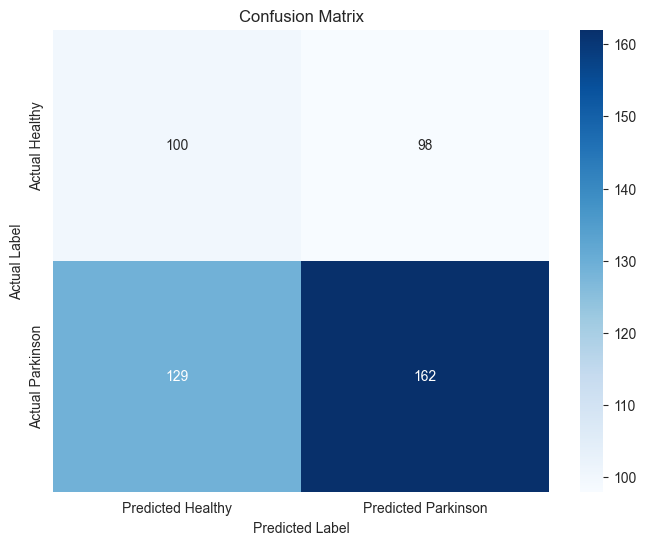

In [28]:
import os
import numpy as np
import librosa
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from pathlib import Path
# --- 1. Audio and Feature Extraction Parameters ---
# These parameters must match the ones used during model training.
SAMPLE_RATE = 16000
DURATION_S = 3
AUDIO_SAMPLES = SAMPLE_RATE * DURATION_S
N_MELS = 30
N_MFCC = 30
N_FFT = 2048
HOP_LENGTH = 512

EXPECTED_FRAMES = int(np.ceil(AUDIO_SAMPLES / HOP_LENGTH))

# --- 2. Paths to Model and Data ---
model_path = BEST_MODEL_PATH
folder_a_path = r"D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower\data\original_A_DEFAULT\healthy_control"
folder_b_path = r"D:\Projects\Voice\Parkinson-s-Disease-Detector-Using-AI\Parkinson-s-Disease-Detector-Using-AI\1\mPower\data\original_A_DEFAULT\parkinson_patient"

# --- 3. Load the Model ---
try:
    model = keras.models.load_model(model_path)
    print("Model loaded successfully! ✅")
    model.summary()
except Exception as e:
    print(f"Error loading model: {e}")
    exit()

def process_and_predict(file_path, model):
    """
    Loads a single WAV file, extracts both Mel Spectrogram and MFCC features,
    and makes a prediction using the model.
    """

    try:

        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Extract Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
        mel_spectrogram = librosa.util.fix_length(mel_spectrogram, size=EXPECTED_FRAMES, axis=1)

        y_preemp = librosa.effects.preemphasis(audio, coef=0.5)
        # Match time dimension
        mfccs = librosa.feature.mfcc(y=y_preemp, sr=sr, n_mfcc=N_MFCC, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH)
        mfccs = librosa.util.fix_length(mfccs, size=EXPECTED_FRAMES, axis=1)

        # Stack them: (n_mfcc + n_mel, frames)
        input_data = np.concatenate((mel_spectrogram, mfccs), axis=1)
        input_data = np.expand_dims(input_data, axis=0)
        # Make prediction
        prediction = model.predict(input_data, verbose=0)
        predicted_label = 1 if prediction[0][0] > 0.5 else 0

        return predicted_label

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def test_files_in_folder(folder_path, model, true_label):
    """
    Iterates through a folder, tests each WAV file, and collects true and predicted labels.
    """
    if not os.path.exists(folder_path):
        print(f"Folder not found: {folder_path}")
        return [], []

    file_list = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    print(f"Found {len(file_list)} WAV files in {folder_path}. Processing all of them...")

    true_labels = []
    predicted_labels = []

    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        predicted_label = process_and_predict(file_path, model)
        if predicted_label is not None:
            true_labels.append(true_label)
            predicted_labels.append(predicted_label)

    return predicted_labels, true_labels

# --- 4. Main Evaluation Logic ---
print("\n--- Starting Model Evaluation ---")
y_true = []
y_pred = []

# Test 'healthy_control' folder (Label 0)
print("\nProcessing 'healthy_control' folder (Label 0)...")
true_a, pred_a = test_files_in_folder(folder_a_path, model, true_label=0)
y_true.extend(true_a)
y_pred.extend(pred_a)

# Test 'parkinson_patient' folder (Label 1)
print("\nProcessing 'parkinson_patient' folder (Label 1)...")
true_b, pred_b = test_files_in_folder(folder_b_path, model, true_label=1)
y_true.extend(true_b)
y_pred.extend(pred_b)

print("\nEvaluation complete. ✅")

# --- 5. Generate and Display Confusion Matrix ---
if len(y_true) > 0 and len(y_pred) > 0:
    print("\n--- Generating Confusion Matrix ---")
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Calculate key metrics
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Print metrics
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall (Sensitivity): {recall:.2f}")
    print(f"F1-Score: {f1_score:.2f}")

    # Plot the matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted Healthy', 'Predicted Parkinson'],
                yticklabels=['Actual Healthy', 'Actual Parkinson'])
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

else:
    print("Not enough data to generate the confusion matrix. Please check your file paths and data.")